In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [30]:
DATA_DIR = "data"
PLOT_DIR = "plots_full_eda"
os.makedirs(PLOT_DIR, exist_ok=True)

# ========== 1️⃣ Load datasets ==========
studentInfo   = pd.read_csv(os.path.join(DATA_DIR, "studentInfo.csv"))
studentReg    = pd.read_csv(os.path.join(DATA_DIR, "studentRegistration.csv"))
studentAssess = pd.read_csv(os.path.join(DATA_DIR, "studentAssessment.csv"))
assessments   = pd.read_csv(os.path.join(DATA_DIR, "assessments.csv"))
studentVle    = pd.read_csv(os.path.join(DATA_DIR, "studentVle.csv"))
vle           = pd.read_csv(os.path.join(DATA_DIR, "vle.csv"))
courses       = pd.read_csv(os.path.join(DATA_DIR, "courses.csv"))

print("✅ All data loaded successfully.")


✅ All data loaded successfully.


In [31]:
# ========== Calculate submission delay ==========
ass_full = studentAssess.merge(assessments, on="id_assessment", how="left")
ass_full["submission_delay"] = ass_full["date_submitted"] - ass_full["date"]

# ========== Aggregate VLE data per student ==========
vle_merged = studentVle.merge(
    vle[["id_site", "activity_type", "week_from", "week_to"]],
    on="id_site", how="left"
)
vle_summary = (
    vle_merged.groupby("id_student")
    .agg({
        "sum_click": "sum",
        "date": "mean",
        "week_from": "mean",
        "week_to": "mean"
    })
    .rename(columns={"date": "avg_access_day"})
    .reset_index()
)


In [32]:
info_reg = studentInfo.merge(
    studentReg[["id_student", "date_registration", "date_unregistration"]],
    on="id_student", how="left"
)

# Label encode categorical variables
le = LabelEncoder()
for col in ["gender", "region", "highest_education", "imd_band", "age_band", "disability", "final_result"]:
    if col in info_reg.columns:
        info_reg[col] = le.fit_transform(info_reg[col].astype(str))


In [33]:
merged = (
    ass_full
    .merge(info_reg, on=["id_student", "code_module", "code_presentation"], how="left")
    .merge(vle_summary, on="id_student", how="left")
    .merge(courses, on=["code_module", "code_presentation"], how="left")
)

print(f"✅ Final merged dataset shape: {merged.shape}")

✅ Final merged dataset shape: (207319, 27)


In [34]:
# ========== 6️⃣ Basic overview ==========
print("\n=== Missing values per column ===")
print(merged.isnull().sum().sort_values(ascending=False).head(20))

print("\n=== Numeric summary ===")
print(merged[["submission_delay", "score", "sum_click", "studied_credits", "num_of_prev_attempts"]].describe())


=== Missing values per column ===
date_unregistration    181482
week_from               40979
week_to                 40979
date                     4018
submission_delay         4018
score                     227
sum_click                  77
avg_access_day             77
date_registration          53
date_submitted              0
id_student                  0
weight                      0
assessment_type             0
code_module                 0
code_presentation           0
is_banked                   0
id_assessment               0
gender                      0
region                      0
disability                  0
dtype: int64

=== Numeric summary ===
       submission_delay          score      sum_click  studied_credits  \
count     203301.000000  207092.000000  207242.000000    207319.000000   
mean         -16.230747      75.402459    2414.614248        77.684004   
std           46.107044      19.081310    2506.119641        37.580250   
min         -246.000000       0

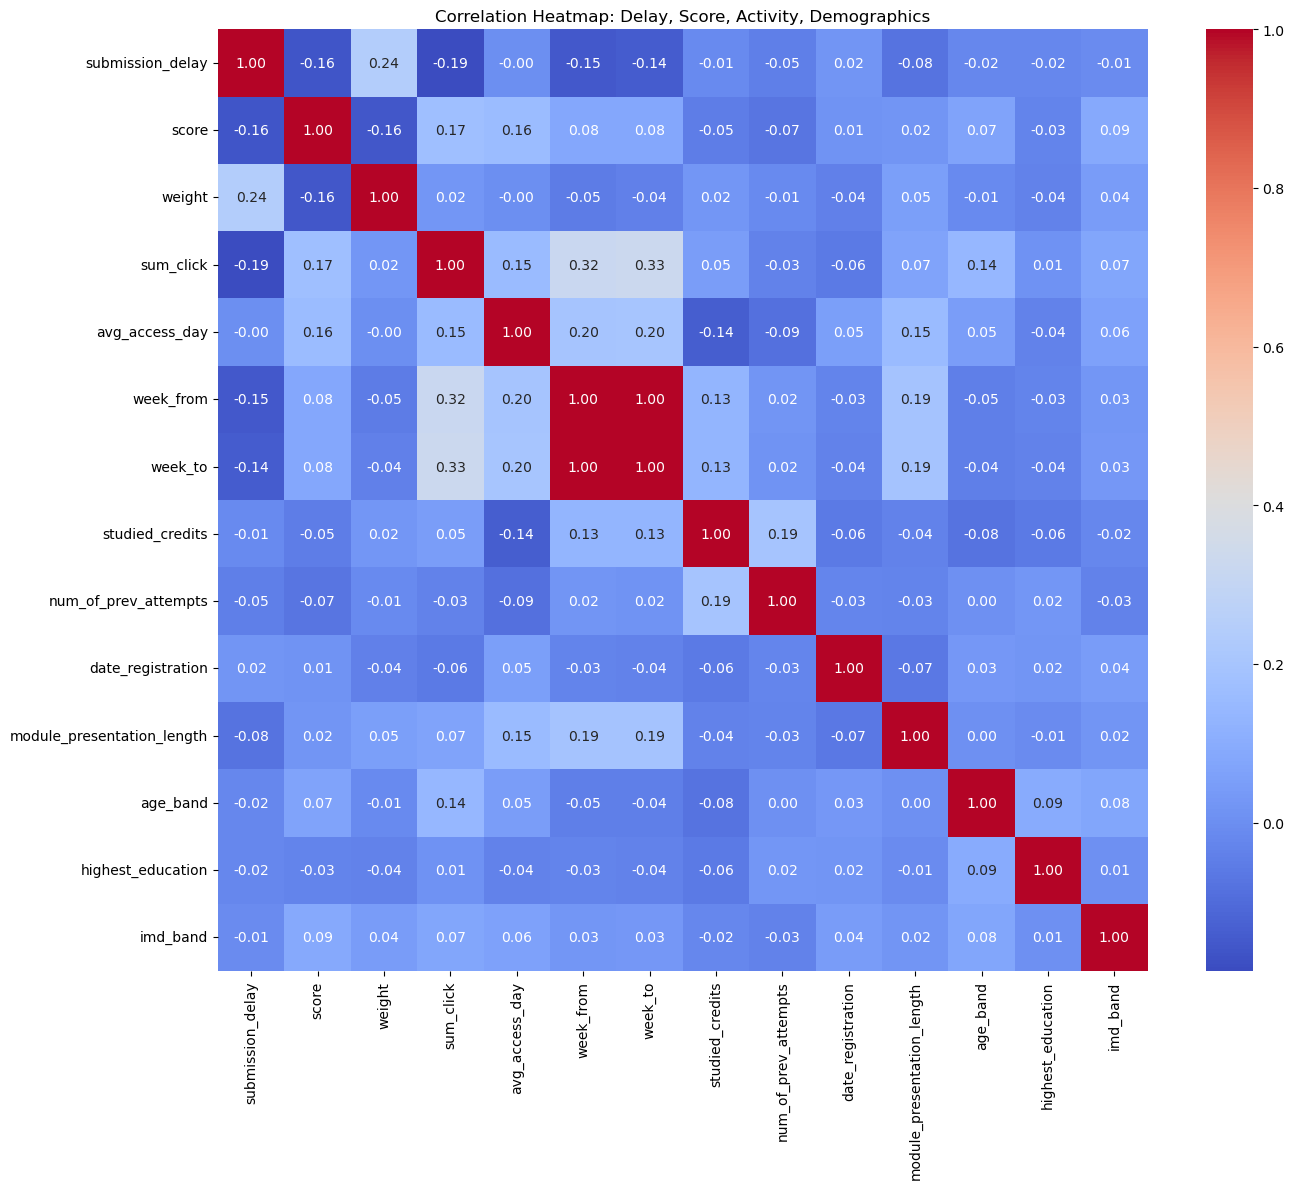


📊 Correlation with submission_delay:
submission_delay              1.000000
weight                        0.243734
date_registration             0.018858
avg_access_day               -0.000487
imd_band                     -0.008296
studied_credits              -0.013808
highest_education            -0.021599
age_band                     -0.021973
num_of_prev_attempts         -0.046618
module_presentation_length   -0.077738
week_to                      -0.142353
week_from                    -0.150696
score                        -0.163408
sum_click                    -0.187156
Name: submission_delay, dtype: float64


In [35]:
num_cols = [
    "submission_delay", "score", "weight", "sum_click", "avg_access_day",
    "week_from", "week_to", "studied_credits", "num_of_prev_attempts",
    "date_registration", "module_presentation_length",
    "age_band", "highest_education", "imd_band"
]

corr = merged[num_cols].corr()

plt.figure(figsize=(14,12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap: Delay, Score, Activity, Demographics")
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "corr_heatmap_full.png"), dpi=300)
plt.show()

print("\n📊 Correlation with submission_delay:")
print(corr["submission_delay"].sort_values(ascending=False))

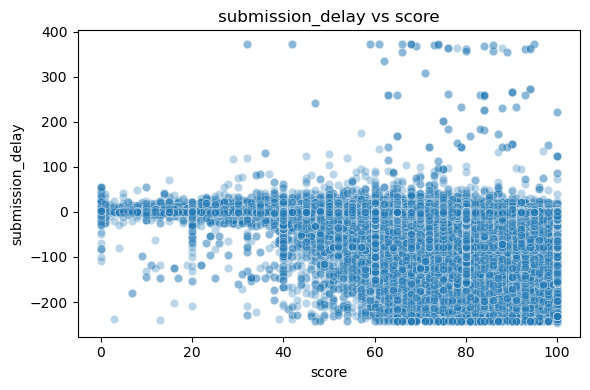

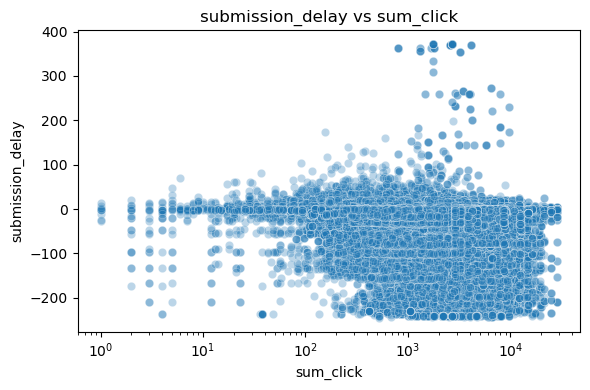

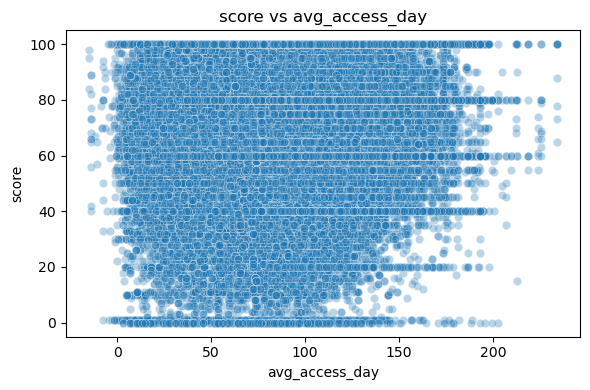

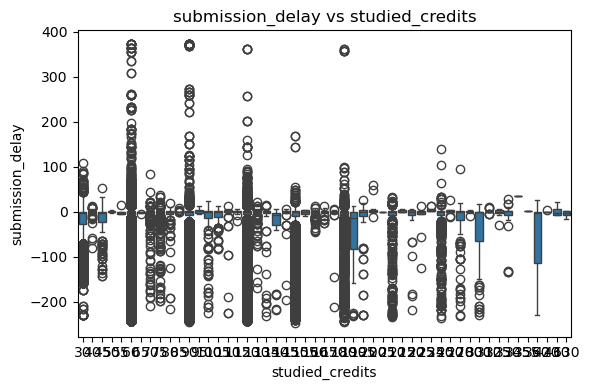

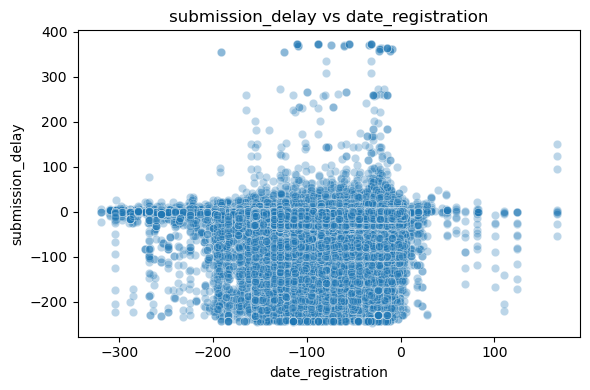

In [36]:
def plot_relation(x, y="submission_delay", kind="scatter", logx=False):
    plt.figure(figsize=(6,4))
    if kind == "scatter":
        sns.scatterplot(data=merged, x=x, y=y, alpha=0.3)
    elif kind == "box":
        sns.boxplot(data=merged, x=x, y=y)
    if logx: plt.xscale("log")
    plt.title(f"{y} vs {x}")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, f"{y}_vs_{x}.png"), dpi=300)
    plt.show()

# Score vs Delay
plot_relation("score")

# Clicks vs Delay
plot_relation("sum_click", logx=True)

# Access day vs Score
plot_relation("avg_access_day", y="score")

# Studied credits vs Delay
plot_relation("studied_credits", kind="box")

# Registration day vs Delay
plot_relation("date_registration")

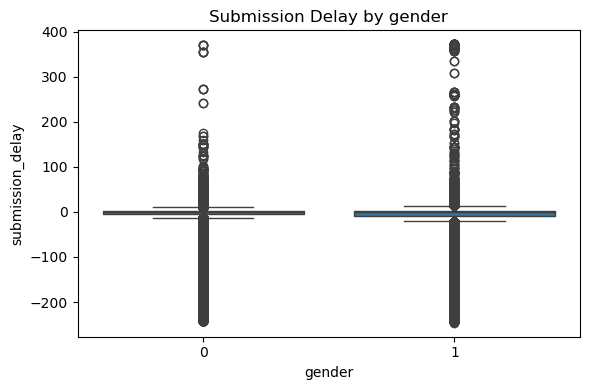

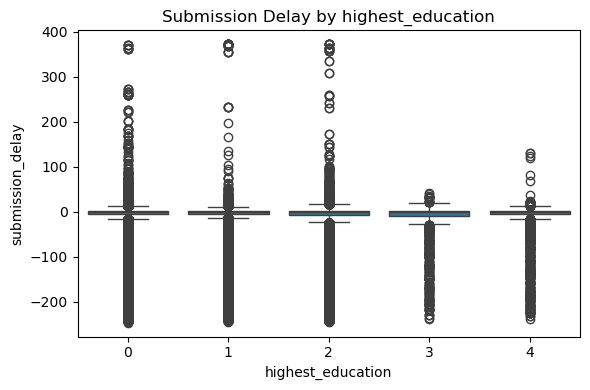

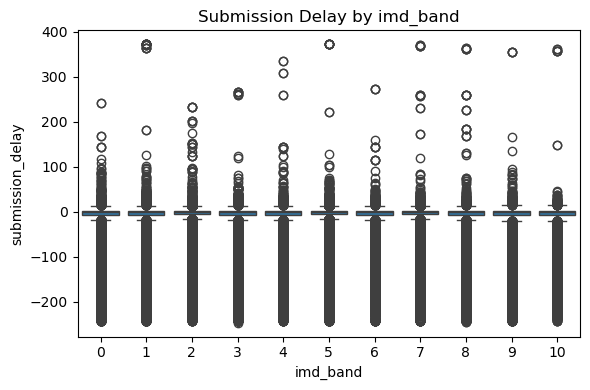

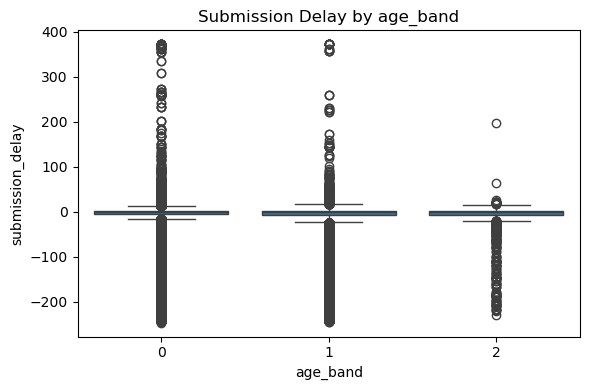

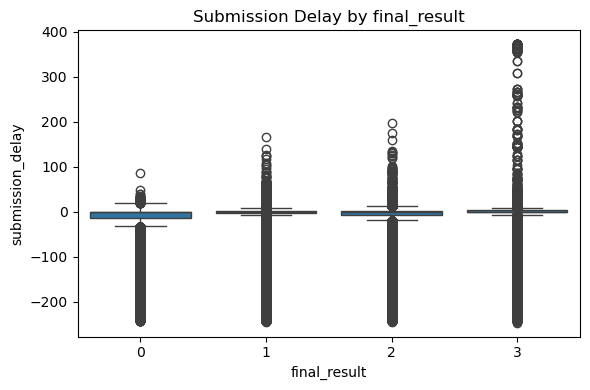

In [37]:

# ========== 9️⃣ Categorical features vs delay ==========
for col in ["gender", "highest_education", "imd_band", "age_band", "final_result"]:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=merged, x=col, y="submission_delay")
    plt.title(f"Submission Delay by {col}")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, f"delay_by_{col}.png"), dpi=300)
    plt.show()

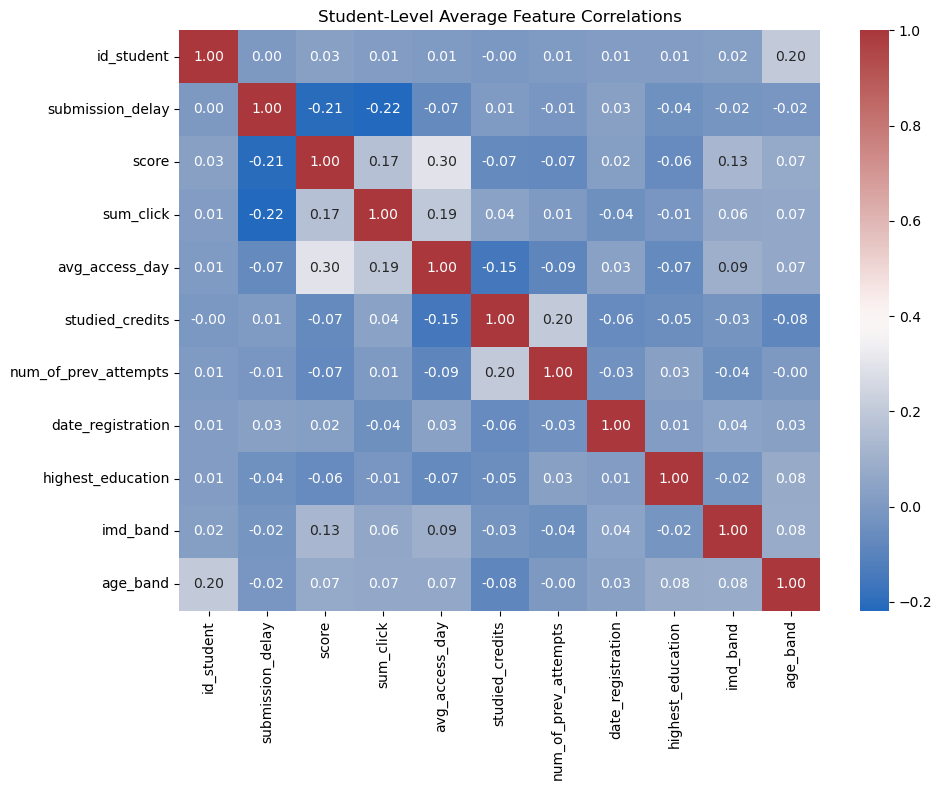


📈 Top features correlated with average submission_delay:
submission_delay        1.000000
date_registration       0.027832
studied_credits         0.007851
id_student              0.000104
num_of_prev_attempts   -0.013670
age_band               -0.016501
imd_band               -0.018637
highest_education      -0.038632
avg_access_day         -0.066314
score                  -0.207617
sum_click              -0.218160
Name: submission_delay, dtype: float64


In [38]:
# ========== 🔟 Personalized analysis (student-level summary) ==========
student_summary = (
    merged.groupby("id_student")
    .agg({
        "submission_delay": "mean",
        "score": "mean",
        "sum_click": "sum",
        "avg_access_day": "mean",
        "studied_credits": "mean",
        "num_of_prev_attempts": "mean",
        "date_registration": "mean",
        "highest_education": "mean",
        "imd_band": "mean",
        "age_band": "mean"
    })
    .reset_index()
)

corr_student = student_summary.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_student, annot=True, cmap="vlag", fmt=".2f")
plt.title("Student-Level Average Feature Correlations")
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "corr_student_level.png"), dpi=300)
plt.show()

print("\n📈 Top features correlated with average submission_delay:")
print(corr_student["submission_delay"].sort_values(ascending=False))